In [2]:
# Set up GPU rendering.
import distutils.util
import os
import subprocess
import time
import itertools

import numpy as np

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

import mujoco
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

env: MUJOCO_GL=egl


In [3]:
with open('nao.xml', 'r') as f:
  xml = f.read()

model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

""

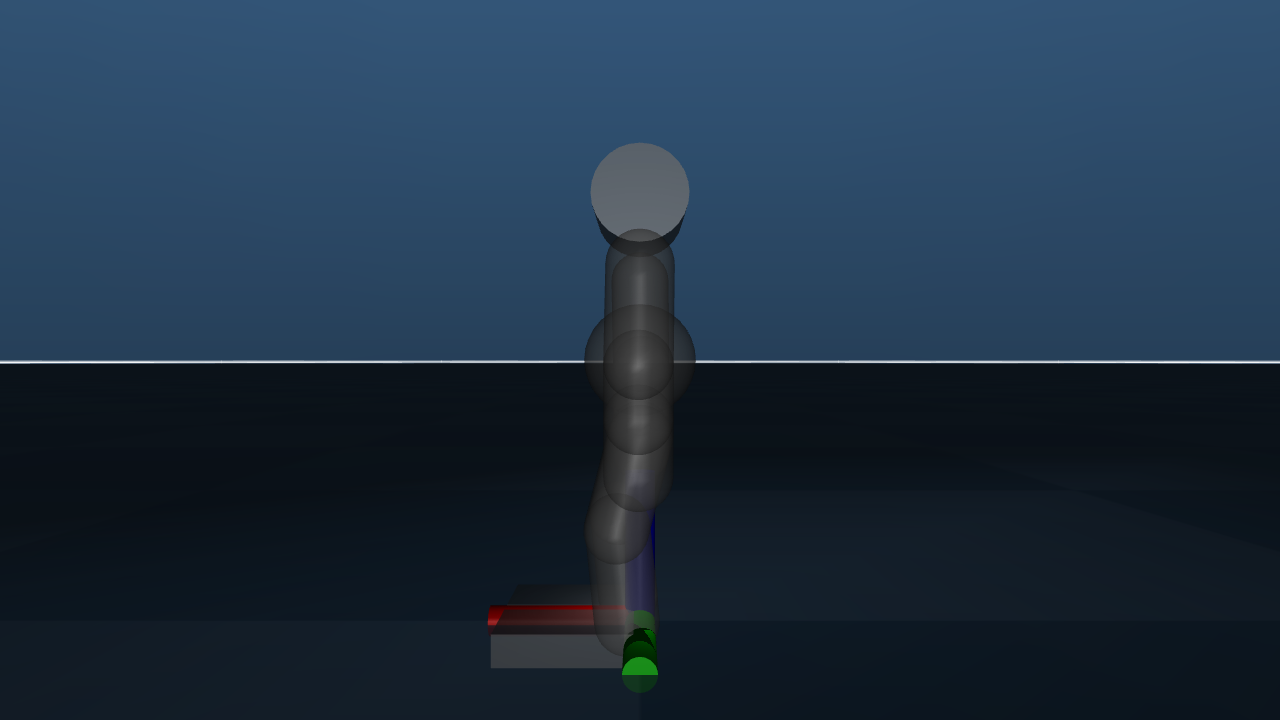

In [4]:
mujoco.mj_resetDataKeyframe(model, data, 1)
with mujoco.Renderer(model, width=1280, height=720) as renderer:
    scene_option = mujoco.MjvOption()
    scene_option.frame = mujoco.mjtFrame.mjFRAME_WORLD | mujoco.mjtFrame.mjFRAME_BODY
    mujoco.mj_forward(model, data)
    renderer.update_scene(data, "robot", scene_option)
    media.show_image(renderer.render())

In [5]:
data.sensor("accelerometer")

<_MjDataSensorViews
  data: array([-17.94 ,   2.551,  41.01 ])
  id: 0
  name: 'accelerometer'
>

In [6]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2

mujoco.mj_resetDataKeyframe(model, data, 1)

frames = []
accel_data = []
gyro_data = []
with mujoco.Renderer(model, width=1280, height=720) as renderer:
    while data.time < DURATION:
      # Set control vector.
      # data.ctrl = np.random.randn(model.nu) * 0.5

      # Step the simulation.
      mujoco.mj_step(model, data)
      accel_data.append(data.sensor("accelerometer").data.copy())
      gyro_data.append(data.sensor("gyroscope").data.copy())

     # Render and save frames.
      if len(frames) < data.time * FRAMERATE:
        # Set the lookat point to the humanoid's center of mass.
        camera.lookat = data.body('torso').subtree_com

        renderer.update_scene(data, camera)
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

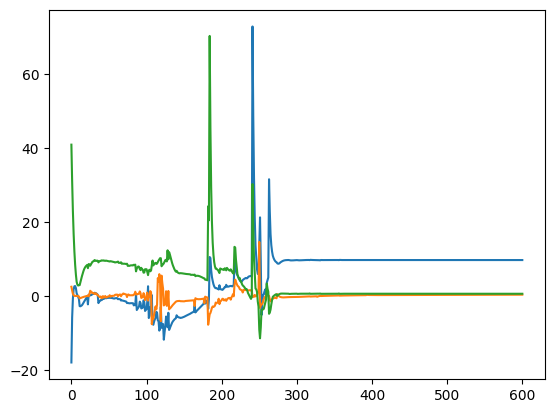

In [7]:
plt.plot(accel_data)

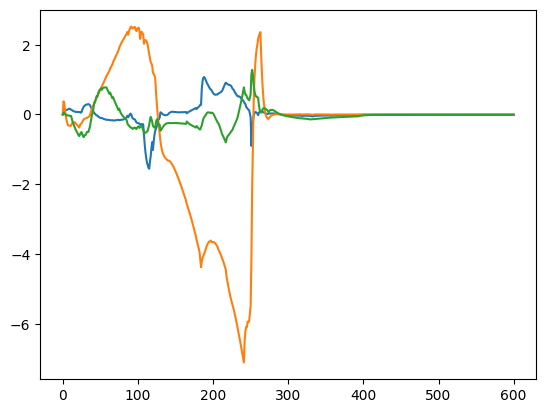

In [8]:
plt.plot(gyro_data)